<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/5_second_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding + first classifier

In [42]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold,train_test_split,cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_predict, cross_validate
import joblib
import ast
import re


In [43]:
data_1 = pd.read_csv("full_final_df.csv")

In [44]:
data_1

,גוף המסמך,מספר הליך,Outcome of case,מספר שופטים,שנת פתיחת ההליך,outcome_category
0,"['פסק דין בתיק ע""פ 9917/02 בבית המשפט העליון ב...","ע""פ 9917/02",O R,3.0,2002,1
1,"['פסק-דין בתיק ע""פ 845/02 בבית המשפט העליון בש...","ע""פ 845/02",O R,3.0,2002,1
2,"['פסק-דין בתיק ע""פ 4379/02 בבית המשפט העליון ב...","ע""פ 4379/02",O A,3.0,2002,0
3,"['פסק דין בתיק ע""פ 9059/03 בבית המשפט העליון ב...","ע""פ 9059/03",O A,3.0,2003,0
4,"['פסק-דין בתיק ע""פ 7075/03 בבית המשפט העליון ב...","ע""פ 7075/03",O A,3.0,2003,0
...,...,...,...,...,...,...
1132,"[' בבית המשפט העליון רע""פ 4357/01 בפני: כבוד ה...","רע""פ 4357/01",NaN,NaN,2001,0
1133,"['פסק דין בתיק רע""פ 1218/21 בבית המשפט העליון ...","רע""פ 1218/21",NaN,NaN,2021,2
1134,"['פסק דין בתיק רע""פ 7316/21 בבית המשפט העליון ...","רע""פ 7316/21",NaN,NaN,2021,0
1135,"['פסק דין בתיק רע""פ 7951/21 בבית המשפט העליון ...","רע""פ 7951/21",NaN,NaN,2021,1


In [45]:
# פונקציה להמרת טקסט שמופיע כרשימה למחרוזת רגילה
def convert_list_to_string(text):
    if isinstance(text, str) and text.startswith("[") and text.endswith("]"):
        try:
            # מנסה להמיר את התוכן בתוך הסוגריים לרשימה אמיתית
            text_list = ast.literal_eval(text)
            # איחוד המחרוזות לרצף טקסט אחד
            return ' '.join(text_list)
        except (ValueError, SyntaxError):
            return text
    return text

# פונקציה לניקוי התווים המיותרים
def clean_text(text):
    if isinstance(text, list):
        text = ' '.join(text)  # הפיכת רשימה למחרוזת
    elif isinstance(text, str):
        # הסרת תווי רווח מיותרים ותווים מיוחדים
        text = re.sub(r'\n+', ' ', text)  # הסרת שורות חדשות מרובות
        text = re.sub(r'\\n', '', text)   # הסרת תווי newline \n מהטקסט
        text = re.sub(r'\\xa0', ' ', text)  # הסרת תווי \xa0 מהטקסט
        text = re.sub(r'\s+', ' ', text)  # הסרת רווחים מרובים
        return text.strip()
    return text

# הדפסת שורות לא קריאות לפני המרה
print("שורות לא קריאות לפני המרה:")
print(data_1["גוף המסמך"].head())

# המרה של הטקסטים הלא קריאים לטקסטים קריאים ושמירה על הדאטה המקורי
data_1["גוף המסמך"] = data_1["גוף המסמך"].apply(clean_text)

print("\nשורות לאחר המרה:")
print(data_1["גוף המסמך"].head())

# file_path = 'full_final_df_cleaned.csv'
# df_full_ra_rap.to_csv(file_path, index=False, encoding='utf-8')

# print(f"הקובץ נשמר בהצלחה בנתיב: {file_path}")


שורות לא קריאות לפני המרה:
0    ['פסק דין בתיק ע"פ 9917/02 בבית המשפט העליון ב...
1    ['פסק-דין בתיק ע"פ 845/02 בבית המשפט העליון בש...
2    ['פסק-דין בתיק ע"פ 4379/02 בבית המשפט העליון ב...
3    ['פסק דין בתיק ע"פ 9059/03 בבית המשפט העליון ב...
4    ['פסק-דין בתיק ע"פ 7075/03 בבית המשפט העליון ב...
Name: גוף המסמך, dtype: object

שורות לאחר המרה:
0    ['פסק דין בתיק ע"פ 9917/02 בבית המשפט העליון ב...
1    ['פסק-דין בתיק ע"פ 845/02 בבית המשפט העליון בש...
2    ['פסק-דין בתיק ע"פ 4379/02 בבית המשפט העליון ב...
3    ['פסק דין בתיק ע"פ 9059/03 בבית המשפט העליון ב...
4    ['פסק-דין בתיק ע"פ 7075/03 בבית המשפט העליון ב...
Name: גוף המסמך, dtype: object


In [46]:
data_1["Outcome of case"].unique()

array(['O R', 'O A', 'O RETURN TO COURT',
       'O Approved in part + Denied in part', 'G R',
       'O COMPROMISE VERDICT', 'O R RETURN TO COURT', 'O WITHDRAWAL',
       'O approved in part + denied in part', 'O R COMPROMISE VERDICT',
       'G A',
       'G R substential matter that was resolved with no consequences on the defendant (as the state consented)',
       'G V (vacated in part)', 'O V', 'O R A',
       "G A at most- defendant was acquitted of one felony with plaintiff's consent. The sunction remained.",
       'Crim + Sent A G', 'G', 'G RETURN TO COURT',
       "G WITHDRAWAL V Appellant was aquitted of one felony with appellee's consent. The rest of the appeal was withdrawaled.",
       'O A WITHDRAWAL',
       'O V denied in part, merged with another procedure in part.',
       'Crim + Sub G R', 'Crim + Sent V Erased (became irrelevant)',
       "Crim + Pro V Erased due to the fact that the procedures un the Magistrates Court wasn't finished",
       'G R RETURN TO COURT

In [47]:
data_1["Type"] = data_1["Outcome of case"].apply(
    lambda x: 1 if isinstance(x, str) and 'G' in x else 0
)


In [48]:
data_1["outcome_category"].unique()

array([1, 0, 2])

In [49]:
data = data_1[data_1["outcome_category"]!=2] # Drop others

In [50]:
data["binary_outcome"] = data["outcome_category"].apply(lambda x: 1 if x == 1 else 0)

<ipython-input-50-8cca5b4870b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["binary_outcome"] = data["outcome_category"].apply(lambda x: 1 if x == 1 else 0)


In [51]:
# הדפסת הערכים הייחודיים של "Outcome of case" לפי הערכים בעמודת "Type"
unique_values_by_type = data.groupby("Type")["Outcome of case"].unique()

# הדפסת הערכים הייחודיים לכל Type
for type_value, unique_values in unique_values_by_type.items():
    print(f"Type {type_value}:")
    for value in unique_values:
        print(value)
    print("=" * 80)

Type 0:
O R
O A
nan
Type 1:
G R
G A
G A at most- defendant was acquitted of one felony with plaintiff's consent. The sunction remained.
Crim + Sent A G
Crim + Sub G R
G R RETURN TO COURT
G A with apellee's consent


In [52]:
data

,גוף המסמך,מספר הליך,Outcome of case,מספר שופטים,שנת פתיחת ההליך,outcome_category,Type,binary_outcome
0,"['פסק דין בתיק ע""פ 9917/02 בבית המשפט העליון ב...","ע""פ 9917/02",O R,3.0,2002,1,0,1
1,"['פסק-דין בתיק ע""פ 845/02 בבית המשפט העליון בש...","ע""פ 845/02",O R,3.0,2002,1,0,1
2,"['פסק-דין בתיק ע""פ 4379/02 בבית המשפט העליון ב...","ע""פ 4379/02",O A,3.0,2002,0,0,0
3,"['פסק דין בתיק ע""פ 9059/03 בבית המשפט העליון ב...","ע""פ 9059/03",O A,3.0,2003,0,0,0
4,"['פסק-דין בתיק ע""פ 7075/03 בבית המשפט העליון ב...","ע""פ 7075/03",O A,3.0,2003,0,0,0
...,...,...,...,...,...,...,...,...
1129,"[' בבית המשפט העליון רע""פ 1764/01 בפני: כבוד ה...","רע""פ 1764/01",NaN,NaN,2001,1,0,1
1132,"[' בבית המשפט העליון רע""פ 4357/01 בפני: כבוד ה...","רע""פ 4357/01",NaN,NaN,2001,0,0,0
1134,"['פסק דין בתיק רע""פ 7316/21 בבית המשפט העליון ...","רע""פ 7316/21",NaN,NaN,2021,0,0,0
1135,"['פסק דין בתיק רע""פ 7951/21 בבית המשפט העליון ...","רע""פ 7951/21",NaN,NaN,2021,1,0,1



## Training

In [53]:
tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")

In [54]:
# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    # המרת הטקסט לפורמט מתאים למודל
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # חישוב האימבדינג של המודל
    outputs = model(**inputs)
    # חישוב ממוצע הוקטורים עבור כל טקסט
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]

In [55]:
# ביטוי לבדיקה
keyword = "העותק כפוף לשינויי עריכה וניסוח"

# בדיקה אילו שורות מכילות את הביטוי
rows_with_keyword = data["גוף המסמך"].str.contains(keyword, na=False)

# סינון שורות שלא מכילות את הביטוי
filtered_data = data[rows_with_keyword]

# הדפסת השורות שלא מכילות את הביטוי
rows_without_keyword = data[~rows_with_keyword]
print("שורות שלא מכילות את הביטוי:\n")
text = (rows_without_keyword["גוף המסמך"].to_string(index=False))
formatted_text = "\n".join([text[i:i+80] for i in range(0, len(text), 80)])
print(formatted_text)
print("##*******************************************************####")

# הדפסת מספר השורות שנמחקו
num_removed = len(rows_without_keyword)
print(f"\nמספר השורות שנמחקו: {num_removed}")

# שמירת הנתונים המסוננים לקובץ חדש
filtered_data.to_csv("filtered_data.csv", index=False, encoding='utf-8')
print("\nהנתונים המסוננים נשמרו לקובץ: 'filtered_data.csv'")

data = filtered_data

שורות שלא מכילות את הביטוי:

['פסק-דין בתיק ע"פ 4379/02 בבית המשפט העליון בש...
['פסק-דין בתיק ע"פ 7075/03 בב
ית המשפט העליון בש...
['פסק דין בתיק ע"פ 5102/03 בבית המשפט העליון בש...
['504 G
ateway Time-out 504 Gateway Time-out ngi...
['פסק-דין בתיק ע"פ 4654/03 בבית המשפ
ט העליון ע"...
['פסק דין בתיק ע"פ 5102/03 בבית המשפט העליון בש...
['{ "status": 
"Failure", "status_code": 400, "c...
['פסק-דין בתיק ע"פ 10360/03 בבית המשפט העלי
ון ב...
['פסק-דין בתיק ע"פ 10596/03 בבית המשפט העליון ב...
['פסק-דין בתיק ע"פ 10
996/03 בבית המשפט העליון ב...
['פסק-דין בתיק ע"פ 9216/03 בבית המשפט העליון בש...

['{ "status": "Failure", "status_code": 422, "c...
['פסק-דין בתיק ע"פ 3948/03 ב
בית המשפט העליון בש...
['פסק-דין בתיק רע"פ 7861/03 בבית המשפט העליון ר...
['פסק 
דין בתיק ע"פ 2132/04 בבית המשפט העליון בש...
['{ "status": "Failure", "status_co
de": 422, "c...
['פסק-דין בתיק ע"פ 10800/04 בבית המשפט העליון ב...
['פסק-דין בתי
ק ע"פ 2597/04 בבית המשפט העליון בש...
['פסק-דין בתיק ע"פ 7895/04 בבית המשפט העלי

binary_outcome
0    704
1    246
Name: count, dtype: int64


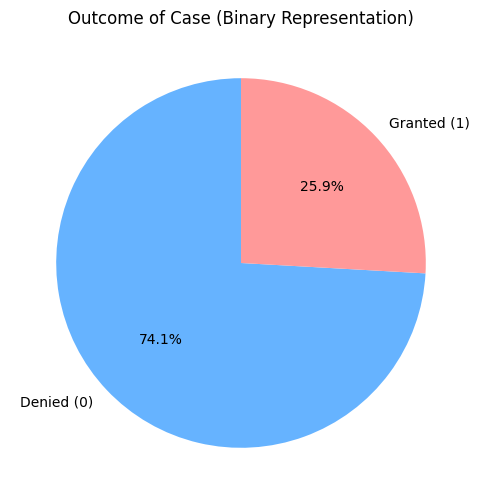

In [56]:
def pie_labels(data):
  binary_counts = data['binary_outcome'].value_counts()
  print(binary_counts)
  labels = ['Denied (0)','Granted (1)']

  plt.figure(figsize=(6, 6))
  plt.pie(binary_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
  plt.title('Outcome of Case (Binary Representation)')

  plt.show()


pie_labels(data)

In [57]:
# פונקציה לחיתוך הטקסט בהתאם לכללים
def trim_text(text,min_length=500,last_sen=30):


    # שמירת אורך מקורי לאבחון
    original_length = len(text)

    # הסרת מספר תווים מסוף הטקסט
    text = text[:-last_sen]

    # חיתוך ל-min_length האחרונים אם הטקסט ארוך יותר מהמינימום
    if len(text) > min_length:
        text = text[-min_length:]

    # הדפסת פידבק רק אם הטקסט עבר שינוי
    if len(text) != original_length:
        print(f"Trimmed Text (Original Length: {original_length}, Trimmed Length: {len(text)}):")
        formatted_text = "\n".join([text[i:i+80] for i in range(0, len(text), 80)])
        print(formatted_text)
        print("##*******************************************************####")
    return text





In [58]:
# הסרת שורות עם ערכים חסרים בעמודת הטקסט או בעמודת המטרה
data = data.dropna(subset=["גוף המסמך", "outcome_category"])

#400 - 50

# חיתוך הטקסטים בעמודת "גוף המסמך"
data["גוף המסמך"] = data["גוף המסמך"].apply(lambda x: trim_text(x, 550, 80))

Streaming output truncated to the last 5000 lines.
ומתאלמוני, אך הקו שנקט בו בית המשפט נראה לנו. המערער הוא איש צעיר ששגה משגה כבד 
–והוא נענש עליו; יש לקוות כי התקופה במאסר תהווה לקח וכי לא יחזור לסורו. בגילועדי
ין פתוחה בפניו הדרך לחיים נורמטיביים, ללימודים ולרכישת מקצוע, ואנו מקוים כייילך 
בה. כאמור, לא נוכל להיעתר לערעור. ניתן היום, י\' בתמוז תשס"ו(6.7.06). ש ו פ ט שו
 פ ט ש ו פ ט _________________________העותק כפוף לשינויי עריכה וניסוח.
##*******************************************************####
Trimmed Text (Original Length: 2702, Trimmed Length: 550):
 מסר מרתיע לרבים, לאמור, גופם של קטינים וחסרי ישע אינו הפקר, והנוטללעצמו את החרו
ת לפגוע בהם, טוב שיידע כי הוא עלול לשלם על כך בחרותו, גם אםנסיבותיו האישיות קשות
 הן. אשר על כן, אנו מקבלים את הערעור, ולנוכחההלכה לפיה בית משפט שלערעור אינו ממצ
ה את הדין עם נאשמים, אנו מעמידים את עונשושל המשיב על 4 שנות מאסר, בשלוש מהן הוא 
ישא בפועל, והיתרה תהיה על-תנאי, ובה הואישא אם יעבור תוך שלוש שנים מיום שחרורו מה
כלא עבירות אלימות מסוג של פש

binary_outcome
0    704
1    246
Name: count, dtype: int64


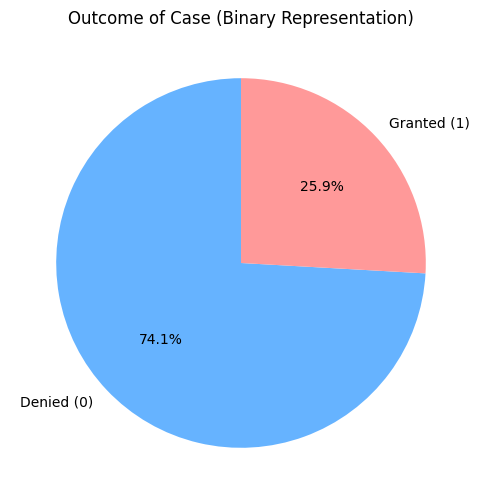

In [59]:
pie_labels(data)

In [60]:
# def train_models(data):
#     # עדכון עמודת המטרה ואימבדינג לאחר חיתוך הטקסטים
#     y_ = data["binary_outcome"].values
#     embeddings = np.array([get_embeddings(text) for text in data["גוף המסמך"]])


#     # הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
#     undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)

#     X_resampled, y_resampled = undersampler.fit_resample(embeddings, y_)

#     # שמירת אינדקסים מקוריים
#     resampled_indices = undersampler.sample_indices_

#     # בדיקת תקינות האינדקסים
#     valid_indices = [i for i in resampled_indices if i < len(data)]
#     if len(valid_indices) < len(resampled_indices):
#         print(f"Warning: {len(resampled_indices) - len(valid_indices)} indices are out of bounds and will be removed.")

#     resampled_indices = valid_indices
#     joblib.dump(resampled_indices, 'second_resampled_indices.pkl')

#     # ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
#     binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values
#     if not np.array_equal(y_resampled[:len(resampled_indices)], binary_outcome_resampled):
#         raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

#     # הגדרת מסווג לוגיסטי עם משקל של 3 עבור קלאס 1
#     classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 1, 1: 3})

#     # התאמת המודל לנתונים המאוזנים
#     classifier.fit(X_resampled[:len(resampled_indices)], y_resampled[:len(resampled_indices)])

#     # הגדרת מדדים לקרוס ולידציה
#     scoring = {
#         'accuracy': make_scorer(accuracy_score),
#         'precision': make_scorer(precision_score, pos_label=1),
#         'recall': make_scorer(recall_score, pos_label=1),
#         'f1': make_scorer(f1_score, pos_label=1)
#     }

#     # ביצוע Cross Validation
#     cv_results = cross_validate(classifier, X_resampled[:len(resampled_indices)], y_resampled[:len(resampled_indices)], cv=5, scoring=scoring)

#     # חיזוי תוויות והסתברויות על כל קפל לצורך קונפיושן מטריקס והסתברויות
#     y_pred = cross_val_predict(classifier, X_resampled[:len(resampled_indices)], y_resampled[:len(resampled_indices)], cv=5)
#     y_prob = cross_val_predict(classifier, X_resampled[:len(resampled_indices)], y_resampled[:len(resampled_indices)], cv=5, method='predict_proba')[:, 1]  # הסתברות לקלאס 1
#     conf_matrix = confusion_matrix(y_resampled[:len(resampled_indices)], y_pred)

#     # הדפסת התוצאות
#     print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
#     print("Mean Accuracy:", cv_results['test_accuracy'].mean())
#     print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
#     print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
#     print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
#     print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
#     print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
#     print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

#     tn, fp, fn, tp = conf_matrix.ravel()

#     # הדפסת הקונפיושן מטריקס עם תוויות
#     print("Confusion Matrix with Labels:")
#     print(f"True Negatives (TN): {tn}")
#     print(f"False Positives (FP): {fp}")
#     print(f"False Negatives (FN): {fn}")
#     print(f"True Positives (TP): {tp}")

#     print("\nConfusion Matrix:")
#     print(f"[[{tn} {fp}]")
#     print(f" [{fn} {tp}]]")

#     # שמירת האינדקסים המקוריים של הדגימות המסומפלות
#     original_indices = data.index[resampled_indices]

#     # הוספת עמודת הסתברויות
#     data['predicted_probabilities'] = np.nan
#     data.loc[original_indices, 'predicted_probabilities'] = y_prob

#     # שמירת המודל והמשאבים
#     joblib.dump(classifier, 'second_classifier_model.pkl')
#     data.to_csv('updated_data_with_probabilities_2.csv', index=False)

#     print("המודל, התוצאות והנתונים נשמרו בהצלחה.")

#     return data,embeddings,classifier,X_resampled,y_resampled, resampled_indices


In [61]:
def train_models(data):
    # עדכון עמודת המטרה ואימבדינג לאחר חיתוך הטקסטים
    y_ = data["binary_outcome"].values
    embeddings = np.array([get_embeddings(text) for text in data["גוף המסמך"]])

    # הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
    undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(embeddings, y_)

    # שמירת אינדקסים מקוריים
    resampled_indices = undersampler.sample_indices_

    # בדיקת תקינות האינדקסים
    valid_indices = [i for i in resampled_indices if i < len(data)]
    if len(valid_indices) < len(resampled_indices):
        print(f"Warning: {len(resampled_indices) - len(valid_indices)} indices are out of bounds and will be removed.")
    resampled_indices = valid_indices
    joblib.dump(resampled_indices, 'second_resampled_indices.pkl')

    # ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
    binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values
    if not np.array_equal(y_resampled[:len(resampled_indices)], binary_outcome_resampled):
        raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

    # הגדרת מסווג לוגיסטי עם משקל של 3 עבור קלאס 1
    classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 1, 1: 3})

    # התאמת המודל לנתונים המאוזנים
    classifier.fit(X_resampled[:len(resampled_indices)], y_resampled[:len(resampled_indices)])

    # הגדרת מדדים לקרוס ולידציה
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, pos_label=1),
        'recall': make_scorer(recall_score, pos_label=1),
        'f1': make_scorer(f1_score, pos_label=1)
    }

    # ביצוע Cross Validation
    cv_results = cross_validate(
        classifier,
        X_resampled[:len(resampled_indices)],
        y_resampled[:len(resampled_indices)],
        cv=5,
        scoring=scoring
    )

    # חיזוי תוויות והסתברויות על כל קפל (Cross Val Predict)
    y_pred = cross_val_predict(
        classifier,
        X_resampled[:len(resampled_indices)],
        y_resampled[:len(resampled_indices)],
        cv=5
    )
    y_prob = cross_val_predict(
        classifier,
        X_resampled[:len(resampled_indices)],
        y_resampled[:len(resampled_indices)],
        cv=5,
        method='predict_proba'
    )[:, 1]  # הסתברות לקלאס 1

    conf_matrix = confusion_matrix(
        y_resampled[:len(resampled_indices)],
        y_pred
    )

    # הדפסת התוצאות
    print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
    print("Mean Accuracy:", cv_results['test_accuracy'].mean())
    print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
    print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
    print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
    print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
    print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
    print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

    tn, fp, fn, tp = conf_matrix.ravel()

    # הדפסת הקונפיושן מטריקס עם תוויות
    print("Confusion Matrix with Labels:")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")

    print("\nConfusion Matrix:")
    print(f"[[{tn} {fp}]")
    print(f" [{fn} {tp}]]")

    # שמירת האינדקסים המקוריים של הדגימות המסומפלות
    original_indices = data.index[resampled_indices]

    # ------------------ הוספת עמודת 'predicted_probabilities' ------------------ #
    data['predicted_probabilities'] = np.nan
    data.loc[original_indices, 'predicted_probabilities'] = y_prob

    # ------------------ הוספת עמודת 'error_type' (TP, FP, TN, FN) ------------------ #
    # ניצור רשימה של סוג השגיאה/הניבוי עבור כל רשומה ברשמפלינג
    error_types = []
    errors = []
    for true_label, predicted_label in zip(y_resampled[:len(resampled_indices)], y_pred):
        if true_label == 1 and predicted_label == 1:
            error_types.append("TP")
            errors.append(0)
        elif true_label == 0 and predicted_label == 0:
            error_types.append("TN")
            errors.append(0)
        elif true_label == 0 and predicted_label == 1:
            error_types.append("FP")
            errors.append(1)
        elif true_label == 1 and predicted_label == 0:
            error_types.append("FN")
            errors.append(1)
        else:
            error_types.append("UNKNOWN")  # למקרה שמשהו לא צפוי

    # יוצרים עמודה ריקה בנתונים המקוריים
    data['error_type'] = np.nan
    data['errors'] = np.nan
    # מחדירים את הערכים רק לאינדקסים שרשמפלנו
    data.loc[original_indices, 'error_type'] = error_types
    data.loc[original_indices, 'errors'] = errors

    # שמירת המודל והמשאבים
    joblib.dump(classifier, 'second_classifier_model.pkl')
    data.to_csv('updated_data_with_probabilities_2.csv', index=False)

    print("המודל, התוצאות והנתונים נשמרו בהצלחה.")

    return data, embeddings, classifier, X_resampled, y_resampled, resampled_indices


In [ ]:
data,embeddings, classifier, X_resampled,y_resampled, resampled_indices = train_models(data)

In [ ]:
data

In [ ]:
data[data['error_type']=="UNKNOWN"].value_counts()

In [ ]:
def print_FN(data, classifier, X_resampled, y_resampled, resampled_indices):
    # חיזוי תוויות על כל קפל לצורך זיהוי FN
    y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)

    # חיזוי הסתברויות
    y_prob = cross_val_predict(classifier, X_resampled, y_resampled, cv=5, method='predict_proba')[:, 1]

    # איתור האינדקסים של FN - תווית אמיתית היא 1 והתחזית היא 0
    fn_indices = np.where((y_resampled == 1) & (y_pred == 0))[0]

    # ודא ש-resampled_indices הוא numpy array
    resampled_indices = np.array(resampled_indices)

    # מיפוי האינדקסים של FN לאינדקסים המקוריים של הנתונים
    original_fn_indices = resampled_indices[fn_indices]

    # קריאת פסקי הדין והערכים בעמודות "Outcome of case", "binary_outcome", "Predicted" ו-"Probability" עבור הדוגמאות שמזוהות כ-FN
    false_negative_rows = data.iloc[original_fn_indices]
    false_negative_probabilities = y_prob[fn_indices]  # ההסתברויות של המודל עבור FN
    false_negative_predicted = y_pred[fn_indices]  # התחזיות של המודל עבור FN

    # ווידוא סינכרון מוחלט של האינדקסים
    if len(false_negative_rows) != len(false_negative_predicted):
        raise ValueError("Mismatch between FN rows and predicted labels!")

    # הדפסת פסקי הדין של FN בצורה מפורמטת עם הערכים המקוריים, התחזית, וההסתברות
    print("False Negative Cases (True Label: 1, Predicted Label: 0):")
    print("=" * 80)

    for i, (index, row, predicted, probability) in enumerate(zip(original_fn_indices, false_negative_rows.iterrows(), false_negative_predicted, false_negative_probabilities), 1):
        _, row_data = row
        print(f"\nCase {i}:")
        print("-" * 80)
        print("Index in Original Data:")
        print(index)
        print("\nOriginal Outcome of Case:")
        print(row_data["Outcome of case"])
        print("\nBinary Outcome (True Label):")
        print(row_data["binary_outcome"])
        print("\nPredicted Label:")
        print(predicted)
        print("\nPredicted Probability:")
        print(f"{probability:.4f}")
        print("\nDocument Body:")
        formatted_text = "\n".join(row_data["גוף המסמך"][j:j + 80] for j in range(0, len(row_data["גוף המסמך"]), 80))
        print(formatted_text)
        print("-" * 80)

    print("=" * 80)


In [ ]:
print_FN(data,classifier,X_resampled,y_resampled, resampled_indices)